In [18]:
%cd /kaggle/working

/kaggle/working


In [6]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from hydra import compose, initialize
from omegaconf import OmegaConf

from utils.metric import score

In [7]:
def hide_submission(sub_df):
    hide_sub_df = sub_df.clone().with_columns(
        [pl.lit(0.0).alias(f"ptend_q0002_{i}") for i in range(12, 22)]
    )
    return hide_sub_df

In [8]:
test_info_df = pl.read_parquet(
    "output/experiments/810_pred_elaps_time/base/test_info_year.parquet"
)
test_info_df.sort("sort_index")

sort_index,original_index,sample_id,location,month,day,seconds,tick,pred,is_duplicated,pred_diff,is_second_year,year,timestamp
u32,u32,str,u32,i64,i64,i64,i64,f32,bool,f32,i32,i32,datetime[μs]
0,138117,"""test_267252""",0,3,1,0,0,0.011544,true,0.527491,0,9,0009-03-01 00:00:00
1,101693,"""test_223108""",1,3,1,0,0,0.012308,true,0.524553,0,9,0009-03-01 00:00:00
2,562692,"""test_781565""",2,3,1,0,0,0.009292,true,0.530859,0,9,0009-03-01 00:00:00
3,504741,"""test_711401""",3,3,1,0,0,0.009514,true,0.530276,0,9,0009-03-01 00:00:00
4,228828,"""test_377300""",4,3,1,0,0,0.013316,true,0.523161,0,9,0009-03-01 00:00:00
…,…,…,…,…,…,…,…,…,…,…,…,…,…
624995,597036,"""test_822994""",227,8,25,28800,24,0.804436,true,0.54411,1,10,0010-08-25 08:00:00
624996,152503,"""test_284808""",228,8,25,28800,24,0.804081,true,0.537386,1,10,0010-08-25 08:00:00
624997,274314,"""test_432560""",229,8,25,28800,24,0.800769,true,0.536229,1,10,0010-08-25 08:00:00


## 提出ファイルチェック

In [9]:
base_sub_path = "gs://kaggle-leap/kami/20240610_ensemble_nelder_mead2_lb078544.parquet"
base_sub_df = pl.read_parquet(base_sub_path)

In [10]:
multi_col_sub_path = "gs://kaggle-leap/kami/experiments/502_latlon_smoothl1_infer_new/all_001/submission.parquet"
multi_col_sub_df = pl.read_parquet(multi_col_sub_path)

In [11]:
multi_col_sub_df.with_columns(base_sub_df["sample_id"]).tail()

sample_id,ptend_t_0,ptend_t_1,ptend_t_2,ptend_t_3,ptend_t_4,ptend_t_5,ptend_t_6,ptend_t_7,ptend_t_8,ptend_t_9,ptend_t_10,ptend_t_11,ptend_t_12,ptend_t_13,ptend_t_14,ptend_t_15,ptend_t_16,ptend_t_17,ptend_t_18,ptend_t_19,ptend_t_20,ptend_t_21,ptend_t_22,ptend_t_23,ptend_t_24,ptend_t_25,ptend_t_26,ptend_t_27,ptend_t_28,ptend_t_29,ptend_t_30,ptend_t_31,ptend_t_32,ptend_t_33,ptend_t_34,ptend_t_35,…,ptend_v_31,ptend_v_32,ptend_v_33,ptend_v_34,ptend_v_35,ptend_v_36,ptend_v_37,ptend_v_38,ptend_v_39,ptend_v_40,ptend_v_41,ptend_v_42,ptend_v_43,ptend_v_44,ptend_v_45,ptend_v_46,ptend_v_47,ptend_v_48,ptend_v_49,ptend_v_50,ptend_v_51,ptend_v_52,ptend_v_53,ptend_v_54,ptend_v_55,ptend_v_56,ptend_v_57,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""test_99994""",0.00005,-0.000014,0.000016,0.000094,0.000125,0.000157,0.000136,0.000101,0.000064,0.000048,0.000037,0.000031,0.000024,0.000017,0.000012,0.00001,0.000009,0.000005,0.000003,0.000006,0.000006,-0.000001,-0.000006,2.5306e-7,-0.000001,-0.000005,-0.00001,-0.000021,-0.000023,-0.000018,-0.000016,-0.000015,-0.000011,-0.000005,-0.000014,-0.00001,…,0.000013,-0.000006,-0.00001,-0.000018,-0.000008,-0.000002,-0.000006,-0.000012,-0.000019,-0.000022,-0.000017,-0.000016,-0.00002,-0.000022,-0.000026,-0.000017,0.000004,0.000012,0.000021,0.000054,0.000058,0.000052,0.000044,0.00003,0.000016,0.000006,0.000001,0.000003,0.000006,398.355195,401.776939,-8.7887e-12,4.4550e-8,168.996437,179.921644,63.441382,26.253855
"""test_99995""",0.000006,-0.00006,-0.000144,-0.000073,-0.000063,-0.000054,-0.000046,-0.000038,-0.000029,-0.000021,-0.000015,-0.000011,-0.000009,-0.000008,-0.000008,-0.000008,-0.000007,-0.000007,-0.000006,-0.000006,-0.000005,-0.000005,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000005,-0.000005,-0.000006,-0.000006,-0.000007,-0.000007,-0.000007,-0.000007,-0.000008,…,1.6019e-9,-2.3881e-8,-2.0371e-9,-1.6359e-8,-8.6881e-9,-8.7230e-9,-8.4384e-9,-1.0448e-8,7.3093e-10,-1.1911e-8,-2.4137e-8,-1.4626e-8,-1.6828e-8,-4.0241e-9,-8.8073e-9,-2.1367e-8,-3.6644e-8,-1.0782e-8,-2.8448e-8,-3.7951e-8,-4.1887e-8,-2.1783e-8,-2.0002e-8,-8.7700e-9,-1.8248e-7,2.5465e-7,-1.2444e-7,0.000003,-0.000004,-2.295682,129.060447,2.1083e-9,1.7344e-9,-1.470787,-0.157183,-0.565996,-0.58987
"""test_99996""",0.000031,0.000006,0.000015,0.000024,0.000042,0.000063,0.000057,0.000038,0.000023,0.000015,0.00001,0.000006,0.000005,0.000005,0.000005,0.000005,0.000004,0.000001,0.000002,3.7992e-7,3.3764e-7,-1.2257e-7,-2.6080e-7,-6.1881e-7,-7.7037e-7,-7.7466e-7,-0.000001,-9.8860e-7,-0.000001,-0.000001,-0.000002,-0.000002,-0.000002,-0.000002,-0.000003,-0.000003,…,-1.2142e-8,6.1130e-10,-5.7148e-9,-3.2736e-9,-1.1217e-8,-5.9065e-9,-1.0385e-8,-4.3288e-9,-1.2205e-8,-4.4341e-9,-5.5610e-9,1.1598e-9,-1.2246e-9,1.8995e-8,-2.4001e-9,5.8757e-9,-2.4029e-9,1.1391e-8,-2.5699e-8,-3.2696e-8,-3.4587e-8,2.2078e-8,1.4498e-8,5.0109e-8,1.8383e-8,1.2089e-7,1.0654e-7,-3.5700e-8,8.6124e-8,68.100157,178.803326,5.8365e-9,6.5500e-9,118.463629,174.194484,64.729002,19.917534
"""test_99997""",-0.000019,-0.000017,-0.000036,-0.000053,-0.000081,-0.000109,-0.000096,-0.000067,-0.000045,-0.000037,-0.000027,-0.00002,-0.000013,-0.000009,-0.000002,0.000001,0.000004,0.000004,0.000001,-2.8651e-8,-0.000004,-0.000006,-0.000009,-0.000015,-0.000022,-0.000026,-0.000033,-0.000032,-0.00003,-0.000027,-0.000025,-0.000024,-0.000025,-0.000024,-0.000027,-0.000026,…,-3.1255e-7,-8.4950e-7,-9.2030e-7,-5.9883e-7,-2.0691e-7,-1.3217e-7,9.7441e-8,0.000004,-0.000008,-0.000007,-0.000001,0.000002,0.000003,0.000004,0.000004,0.000004,0.000003,0.000002,0.000002,0.000002,0.000002,0.000002,0.000001,6.8404e-7,-6.2819e-7,-0.000001,-0.00

In [12]:
preds = base_sub_df[:, 1:].to_numpy()
labels = multi_col_sub_df[:, 1:].to_numpy()

In [13]:
# 埋める前後でスコアが大きく変わらないかをチェック
preds = base_sub_df[:, 1:].to_numpy()
labels = multi_col_sub_df[:, 1:].to_numpy()
_predict_df = pd.DataFrame(
    preds, columns=[i for i in range(preds.shape[1])]
).reset_index()
_label_df = pd.DataFrame(
    labels, columns=[i for i in range(labels.shape[1])]
).reset_index()
r2_scores = score(_label_df, _predict_df, "index", multioutput="raw_values")

r2_score = float(np.array(r2_scores).mean())
print(f"{r2_score=}")

r2_score=0.9513133270160357


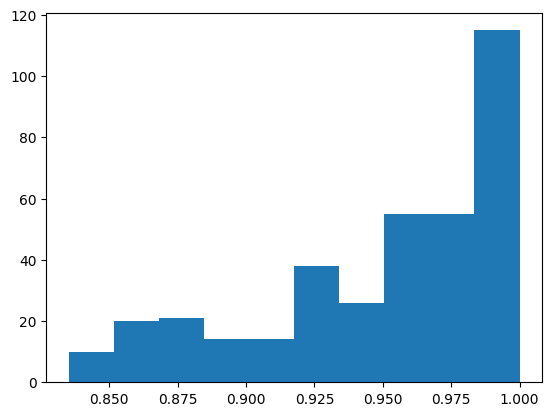

In [14]:
import matplotlib.pyplot as plt

plt.hist(r2_scores)
plt.show()

In [15]:
# hide
hide_multi_col_sub_df = hide_submission(multi_col_sub_df)
print(hide_multi_col_sub_df.shape)
hide_multi_col_sub_df[:, 120:150].head()

(625000, 369)


ptend_q0001_59,ptend_q0002_0,ptend_q0002_1,ptend_q0002_2,ptend_q0002_3,ptend_q0002_4,ptend_q0002_5,ptend_q0002_6,ptend_q0002_7,ptend_q0002_8,ptend_q0002_9,ptend_q0002_10,ptend_q0002_11,ptend_q0002_12,ptend_q0002_13,ptend_q0002_14,ptend_q0002_15,ptend_q0002_16,ptend_q0002_17,ptend_q0002_18,ptend_q0002_19,ptend_q0002_20,ptend_q0002_21,ptend_q0002_22,ptend_q0002_23,ptend_q0002_24,ptend_q0002_25,ptend_q0002_26,ptend_q0002_27,ptend_q0002_28
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-3.2238e-8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-3.4732e-52,-1.1230e-50,-3.7416e-46,-0.0,-0.0,-3.6225e-41
1.0373e-9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-4.6953e-38,-1.1300e-34,-0.0,-0.0
-1.6156e-8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.5470e-55,-4.8672e-50,-1.7166e-45,-3.0009e-41,-1.6681e-36,-4.6263e-32,-4.1423e-29
-9.8703e-8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-2.1850e-33,-1.4489e-28,-9.7428e-24
-1.3557e-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.2989e-46,-9.8736e-42,-4.5247e-37,-1.4539e-32,-4.3046e-28,-1.1317e-23,-1.7664e-19


In [17]:
hide_multi_col_sub_df.write_parquet(
    "output/hide_502_latlon_smoothl1_infer_new_all_001_submission.parquet"
)

## timestamp 埋め

In [19]:
time_sub_path = "gs://kaggle-leap/kami/experiments/610_sim6/all/submission.parquet"
time_sub_df = pl.read_parquet(time_sub_path)
time_sub_df.tail()

sample_id,ptend_t_0,ptend_t_1,ptend_t_2,ptend_t_3,ptend_t_4,ptend_t_5,ptend_t_6,ptend_t_7,ptend_t_8,ptend_t_9,ptend_t_10,ptend_t_11,ptend_t_12,ptend_t_13,ptend_t_14,ptend_t_15,ptend_t_16,ptend_t_17,ptend_t_18,ptend_t_19,ptend_t_20,ptend_t_21,ptend_t_22,ptend_t_23,ptend_t_24,ptend_t_25,ptend_t_26,ptend_t_27,ptend_t_28,ptend_t_29,ptend_t_30,ptend_t_31,ptend_t_32,ptend_t_33,ptend_t_34,ptend_t_35,…,ptend_v_31,ptend_v_32,ptend_v_33,ptend_v_34,ptend_v_35,ptend_v_36,ptend_v_37,ptend_v_38,ptend_v_39,ptend_v_40,ptend_v_41,ptend_v_42,ptend_v_43,ptend_v_44,ptend_v_45,ptend_v_46,ptend_v_47,ptend_v_48,ptend_v_49,ptend_v_50,ptend_v_51,ptend_v_52,ptend_v_53,ptend_v_54,ptend_v_55,ptend_v_56,ptend_v_57,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""test_99994""",0.00005,-0.000014,0.000016,0.000092,0.000123,0.000154,0.000134,0.000101,0.000064,0.000046,0.000037,0.000031,0.000023,0.000017,0.000011,0.00001,0.000009,0.000005,0.000003,0.000006,0.000006,-0.000001,-0.000008,0.000003,-0.000004,-0.000003,-0.000007,-0.000024,-0.000027,-0.000007,-0.000019,-0.00002,-0.000004,-0.000011,-0.000009,-0.000013,…,0.000018,-0.000009,-0.000014,-0.000019,-0.000008,-0.000002,-0.000008,-0.000024,-0.000039,-0.000042,-0.000034,-0.000014,-0.000007,0.000005,0.000005,0.000009,0.000015,0.000017,0.000026,0.000057,0.00006,0.000051,0.000039,0.000026,0.000014,0.000005,7.9935e-7,8.0221e-7,0.000005,374.145874,400.883399,4.6892e-11,6.6643e-8,159.981086,166.362864,60.629005,25.554155
"""test_99995""",0.000008,-0.000058,-0.000152,-0.000074,-0.000063,-0.000054,-0.000045,-0.000037,-0.000029,-0.000021,-0.000015,-0.000011,-0.000009,-0.000008,-0.000008,-0.000008,-0.000007,-0.000007,-0.000006,-0.000006,-0.000005,-0.000004,-0.000004,-0.000004,-0.000003,-0.000003,-0.000003,-0.000004,-0.000004,-0.000006,-0.000006,-0.000006,-0.000007,-0.000006,-0.000008,-0.000007,…,-2.3105e-8,-2.5482e-8,-3.1484e-8,-7.3379e-9,-2.3304e-8,-9.3158e-9,-2.7665e-8,-1.0579e-8,-2.3535e-12,-9.5928e-10,-1.6203e-8,-9.3337e-9,7.8392e-9,-5.3038e-9,-1.3000e-8,-1.4621e-8,3.8273e-9,-3.2322e-8,-4.5684e-8,-1.4936e-8,4.4368e-8,4.3760e-8,3.2295e-8,-2.4409e-8,-3.0973e-8,7.5367e-7,1.3501e-7,0.000006,-0.000008,-2.634993,130.157033,1.9060e-9,2.7167e-9,-0.234532,2.102584,-0.393977,-1.247709
"""test_99996""",0.000031,0.000006,0.000015,0.000023,0.000037,0.000059,0.000054,0.000037,0.000022,0.000014,0.000009,0.000006,0.000004,0.000004,0.000005,0.000004,0.000004,0.000001,0.000002,-2.3788e-8,4.9351e-8,-1.5949e-7,-5.0052e-7,-8.6544e-7,-0.000001,-0.000001,-0.000001,-8.6544e-7,-8.1495e-7,-0.000001,-0.000001,-0.000002,-0.000002,-0.000002,-0.000002,-0.000003,…,-5.2730e-9,-4.0718e-10,1.8095e-10,3.7128e-9,-1.3064e-9,5.9373e-9,1.9330e-8,8.8009e-9,2.2802e-8,-2.0961e-10,1.1089e-9,-1.0145e-8,-1.6338e-10,7.9844e-9,-1.8286e-8,5.5609e-9,-1.7030e-8,-6.1971e-9,6.5645e-9,-8.3043e-9,-5.9426e-9,-1.1473e-8,-4.1505e-8,-6.8709e-8,-1.7125e-8,-4.5540e-8,-4.4208e-9,-4.2289e-8,-8.9592e-8,68.148364,179.68733,5.8668e-9,4.7717e-9,118.497924,177.037129,62.796541,17.045815
"""test_99997""",-0.000018,-0.000014,-0.000037,-0.000055,-0.00008,-0.000107,-0.000098,-0.000067,-0.000044,-0.000036,-0.000027,-0.00002,-0.000013,-0.000009,-0.000002,0.000001,0.000004,0.000004,0.000001,0.000002,-0.000007,-0.000006,-0.000008,-0.000015,-0.00002,-0.000018,-0.000032,-0.000036,-0.000027,-0.000024,-0.000029,-0.00002,-0.000018,-0.000039,-0.000028,-0.000028,…,-1.4143e-7,-0.000002,-0.000002,-0.000001,2.7967e-8,-0.000001,0.000001,0.000007,-0.000018,-0.000028,-0.000012,-0.000003,0.000009,0.000022,0.000029,0.00003,0.000029,0.000024,0.000018,0.000011,0.000004,-0.000003,-0.000009,-0.000014,-0.000019,-0.000023,-0.000026,-

In [20]:
class_exps = ["704_diff_top3/all"]

In [21]:
class_preds_list = []
for class_exp in class_exps:
    class_pred_df = pl.read_parquet(
        f"gs://kaggle-leap/kami/experiments/{class_exp}/test_predict1.parquet"
    )
    class_preds = class_pred_df.get_column("0").to_numpy().reshape(-1)
    class_preds_list.append(class_preds)
class_preds = np.mean(class_preds_list, axis=0)

class_pred_df.tail()

index,0,1,2,3,4,5,6,7,8,9,10
i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
624995,0.999998,3.5536e-7,2.8944e-12,3.9998e-9,1.3041e-9,6.6387e-8,7.7986e-9,1.0392e-9,1.2641e-7,7.0632e-9,9.2192e-7
624996,0.000011,0.99997,0.000016,3.0027e-9,5.7119e-11,1.5711e-11,0.000003,7.9003e-10,2.6562e-11,9.9551e-12,2.6195e-7
624997,1.0,9.5750e-8,7.9714e-13,2.2783e-11,7.0562e-14,7.0815e-12,2.6643e-7,4.0843e-11,1.0627e-8,9.3115e-11,4.0896e-9
624998,2.7905e-8,0.999998,3.3991e-8,3.9214e-8,0.000001,3.6363e-11,2.4577e-8,1.8824e-10,2.0587e-9,5.1136e-12,4.2765e-7
624999,4.7162e-7,5.6062e-7,5.3258e-10,3.1356e-12,5.2200e-9,0.000001,1.5995e-7,2.9758e-9,1.0296e-9,3.3948e-7,0.999997


In [24]:
# 閾値以上の行について、カラムごとにR2を計算して一定値以上であれば置き換えを行う
from sklearn.metrics import r2_score

threshold = 0.99995
replace_index = class_preds > threshold
print(f"replace num:{replace_index.sum()} rate:{replace_index.sum()/len(class_preds)}")

replace_sub_df = multi_col_sub_df.clone()
r2_score_vals = []

for col in multi_col_sub_df.columns[1:]:
    time_pred = time_sub_df[col].to_numpy()
    base_pred = multi_col_sub_df[col].to_numpy()
    r2_score_val = r2_score(
        base_pred[replace_index],
        time_pred[replace_index],
    )
    r2_score_val2 = r2_score(
        time_pred[replace_index],
        base_pred[replace_index],
    )
    if (r2_score_val > 0.5) & (r2_score_val2 > 0.5):
        replace_pred = multi_col_sub_df[col].to_numpy().copy()
        replace_pred[replace_index] = time_pred[replace_index]
        replace_sub_df = replace_sub_df.with_columns(
            pl.Series(name=col, values=replace_pred)
        )
        r2_score_vals.append(r2_score_val)
    else:
        print(col, r2_score_val, r2_score_val2)

replace num:120881 rate:0.1934096


In [ ]:
replace_sub_df.write_parquet(
    "output/502_latlon_smoothl1_infer_new_all_001_610_sim6_all_submission.parquet"
)
replace_sub_df.head()

## similarity が低いやつを削除(不要)

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(preds)

StandardScaler()

In [12]:
from sklearn.preprocessing import normalize

_preds = scaler.transform(preds)
_labels = scaler.transform(labels)

In [13]:
_preds = normalize(_preds, axis=1, norm="l2")
_labels = normalize(_labels, axis=1, norm="l2")
_labels.shape

(625000, 368)

In [14]:
similarity = (_preds * _labels).sum(axis=1)
similarity.shape

(625000,)

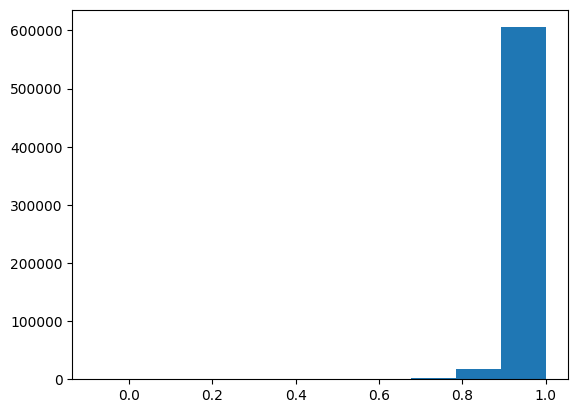

In [15]:
import matplotlib.pyplot as plt

plt.hist(similarity)
plt.show()

In [35]:
# 埋める前後でスコアが大きく変わらないかをチェック
rate = 0.2
preds = base_sub_df[:, 1:].to_numpy()[similarity > rate]
labels = multi_col_sub_df[:, 1:].to_numpy()[similarity > rate]
_predict_df = pd.DataFrame(
    preds, columns=[i for i in range(preds.shape[1])]
).reset_index()
_label_df = pd.DataFrame(
    labels, columns=[i for i in range(labels.shape[1])]
).reset_index()
r2_scores = score(_label_df, _predict_df, "index", multioutput="raw_values")

r2_score = float(np.array(r2_scores).mean())
print(f"{r2_score=}")

r2_score=0.9519432534601444


In [34]:
test_info_df.filter(similarity < 0.2).sort("timestamp")

sort_index,original_index,sample_id,location,month,day,seconds,tick,pred,is_duplicated,pred_diff,is_second_year,year,timestamp
u32,u32,str,u32,i64,i64,i64,i64,f32,bool,f32,i32,i32,datetime[μs]
149554,368083,"""test_545914""",178,7,8,57600,48,0.20007,true,0.539636,0,9,0009-07-08 16:00:00
624792,2318,"""test_102800""",24,8,25,28800,24,0.802709,true,0.539911,1,10,0010-08-25 08:00:00
624770,3138,"""test_103819""",2,8,25,28800,24,0.797855,true,0.539951,1,10,0010-08-25 08:00:00
624872,15470,"""test_118638""",104,8,25,28800,24,0.796433,true,0.530097,1,10,0010-08-25 08:00:00
624782,17992,"""test_121682""",14,8,25,28800,24,0.798688,true,0.539699,1,10,0010-08-25 08:00:00
…,…,…,…,…,…,…,…,…,…,…,…,…,…
624929,611774,"""test_840780""",161,8,25,28800,24,0.792691,true,0.52871,1,10,0010-08-25 08:00:00
624869,612434,"""test_84688""",101,8,25,28800,24,0.795921,true,0.531137,1,10,0010-08-25 08:00:00
624854,614770,"""test_87551""",86,8,25,28800,24,0.794655,true,0.528362,1,10,0010-08-25 08:00:00


In [28]:
similarity.shape

(625000,)